# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold
from IPython.display import display, HTML
import seaborn as sns

# **Data Cleaning**

### **Importing data**


In [2]:
heartFailureClinicalRecord = pd.read_csv('heart_failure_clinical_records_dataset.csv',header=0)
heartFailureClinicalRecord.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,45.0,0,582,0,80,0,263358.03,1.18,137,0,0,63,0
1,54.0,1,427,0,70,1,151000.00,9.00,137,0,0,196,1
2,65.0,0,157,0,65,0,263358.03,1.50,138,0,0,10,1
3,50.0,0,582,0,62,1,147000.00,0.80,140,1,1,192,0
4,60.0,0,3964,1,62,0,263358.03,6.80,146,0,0,43,1


In [3]:
print(f"Shape of the dataset is {heartFailureClinicalRecord.shape} \n")

Shape of the dataset is (299, 13) 



### **Check for missing values**


In [4]:
print(f"\nNumber of missing values for each feature:")
print(heartFailureClinicalRecord.isnull().sum())


Number of missing values for each feature:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


### **Drop irrelevant columns**

Make the data clean for further investigation. The dropped colums are not of interest in the investigation.

In [5]:
heartFailureClinicalRecord = heartFailureClinicalRecord.drop(columns=['time'])

### **Rename the column**

In [6]:
heartFailureClinicalRecord.rename(columns={'DEATH_EVENT':'death_event'}, inplace = True)

### **Detect outliers**



Rounding up the the value of age from 60.667 to 61

In [7]:
heartFailureClinicalRecord['age'].mask(
    cond=(heartFailureClinicalRecord['age'] == 60.667), other=61, inplace=True)
heartFailureClinicalRecord.astype({'age': 'int64'}).dtypes

age                           int64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
death_event                   int64
dtype: object

There are only 2 outliers, and normally the ejection fraction of around 50 to 70 is considered as high. Hence, those outliers are removed.

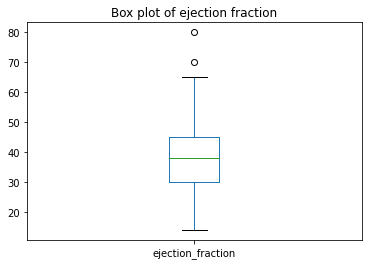

In [8]:
heartFailureClinicalRecord['ejection_fraction'].plot(kind='box', title='Box plot of ejection fraction', figsize=(6,4))

In [9]:
heartFailureClinicalRecord = heartFailureClinicalRecord[heartFailureClinicalRecord['ejection_fraction'] < 70]

The outliers from creatinine_phosphokinase, platelets, serum_creatinine and serum_sodium are kept because they fall in possible range of values.

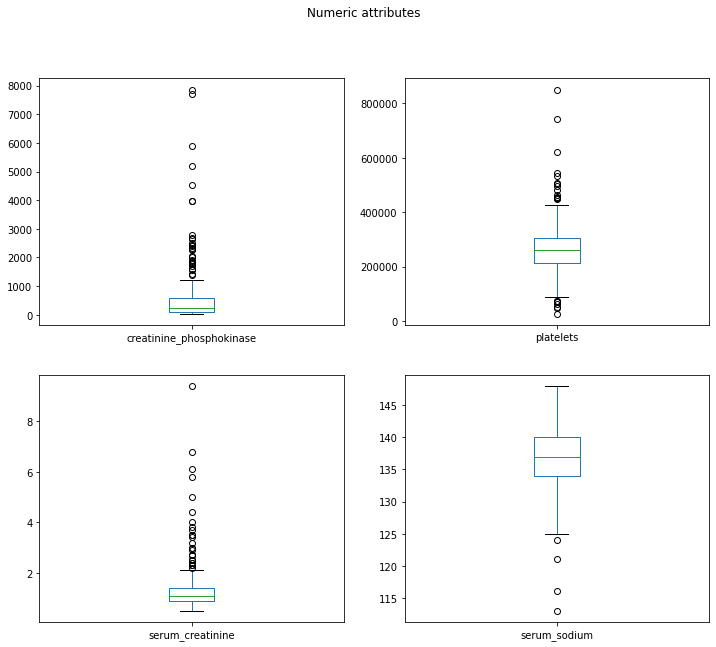

In [10]:
cols = ['creatinine_phosphokinase', 'platelets', 'serum_creatinine', 'serum_sodium']
heartFailureClinicalRecord[cols].plot(kind='box', subplots=True, layout=(2,2), figsize=(12,10), title='Numeric attributes')
plt.show()

### **Explanatory variables**

* *age*: Age of the patient: **years**.
* *anaemia*: Decrease of red blood cells or hemoglobin (boolean): **0: false & 1: true**.
* *creatinine_phosphokinase (cpk)*: Level of the CPK enzyme in the blood: **mcg/L**.
* *diabetes*: If the patient has diabetes (boolean): **0: false & 1: true**.
* *ejection_fraction*: Percentage of blood leaving: **%**.
* *high_blood_pressure*: If a patient has hypertension (boolean): **0: false & 1: true**.
* *platelets*: Platelets in the blood: **kiloplatelets/mL**.
* *serum_creatinine*: Level of creatinine in the blood: **mg/dL**.
* *serum_sodium*: Level of sodium in the blood: **mEq/L**.
* *sex*: Gender of the patient (boolean): **0: female & 1: male**.
* *smoking*: If the patient smokes (boolean): **0: false & 1: true**.

### **Target variable**

*death_event*: If the patient died during the follow-up period (boolean): **0: false & 1: true**.

# **Data Exploration**

In [11]:
features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
display(HTML('<b>Table 1: Summary of continuous features</b>'))
heartFailureClinicalRecord[features].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,60.912458,582.360269,37.835017,263736.339125,1.368990,136.622896
std,11.892498,973.518622,11.470426,97915.822481,0.938731,4.427251
min,40.000000,23.000000,14.000000,25100.000000,0.500000,113.000000
25%,51.000000,115.000000,30.000000,213000.000000,0.900000,134.000000
50%,60.000000,249.000000,38.000000,262000.000000,1.100000,137.000000
75%,70.000000,582.000000,45.000000,304000.000000,1.400000,140.000000
max,95.000000,7861.000000,65.000000,850000.000000,9.400000,148.000000


In [12]:
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
display(HTML('<b>Table 2: Summary of boolean features</b>'))
for feature in boolean_features:
    print(heartFailureClinicalRecord[feature].value_counts())

0    169
1    128
Name: anaemia, dtype: int64
0    172
1    125
Name: diabetes, dtype: int64
0    193
1    104
Name: high_blood_pressure, dtype: int64
1    194
0    103
Name: sex, dtype: int64
0    201
1     96
Name: smoking, dtype: int64


In [13]:
display(HTML('<b>Table 3: Summary of target feature</b>'))
heartFailureClinicalRecord['death_event'].value_counts()

0    202
1     95
Name: death_event, dtype: int64

### **Explore each column**



##### **Pie chart of anaemia, diabetes, high blood pressure and smoking**

1. 43.1% of patients have anaemia when 56.9% do not have.

2. 42.1% of patients have diabetes when 57.9% do not have.

3. In 100 patients, there exists 35 patients who have high blood pressure and 65 patients do not have.

4. 32.3% of patients smoke and 67.7% do not smoke.

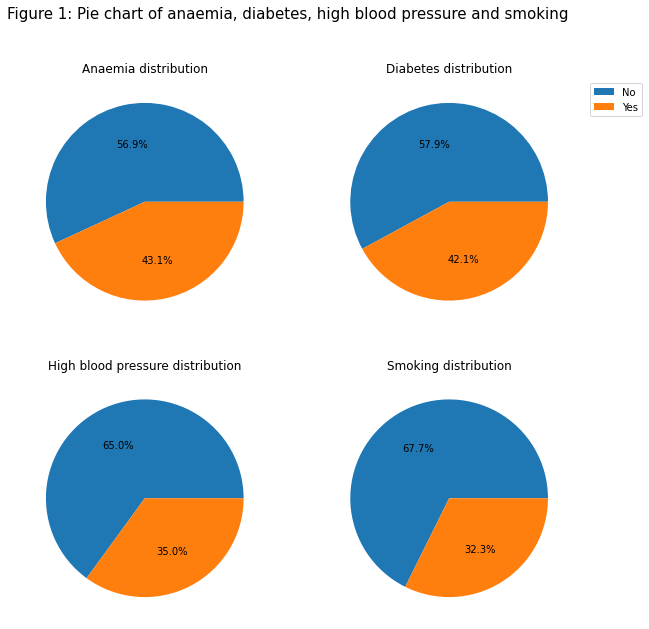

In [14]:
labels = ['No', 'Yes']
cols = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking']
values = []
colors = ['#4F6272', '#B7C3F3']

for col in cols:
    yes = heartFailureClinicalRecord[heartFailureClinicalRecord[col] == 1]
    no = heartFailureClinicalRecord[heartFailureClinicalRecord[col] == 0]
    values.append([len(no), len(yes)])
    
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2,figsize=(10,10))
    
plt.suptitle("Figure 1: Pie chart of anaemia, diabetes, high blood pressure and smoking", fontsize=15)

ax1.pie(values[0], autopct = '%1.1f%%')
ax1.set_title('Anaemia distribution')

ax2.pie(values[1], autopct = '%1.1f%%')
ax2.set_title('Diabetes distribution')
ax2.legend(labels, bbox_to_anchor=(0.8,0,0.5,1))

ax3.pie(values[2], autopct = '%1.1f%%')
ax3.set_title('High blood pressure distribution')

ax4.pie(values[3], autopct = '%1.1f%%')
ax4.set_title('Smoking distribution')

plt.show()

##### **Pie chart of death event distribution**

68% of patients dead and 32% survived. The data is imbalanced.

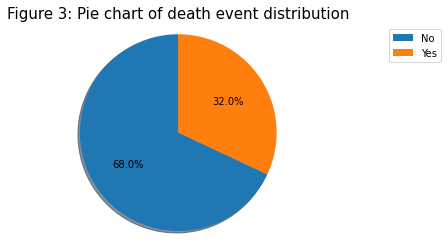

In [15]:
death_no = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0)]
death_yes = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1)]
label = 'No', 'Yes'
size = [len(death_no), len(death_yes)]

plt.pie(size, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.legend(label, bbox_to_anchor=(0.8,0,0.5,1))
plt.title('Figure 3: Pie chart of death event distribution', fontsize=15)
plt.show()

##### **Age Distribution**

The age of patients spread widely from 40 to 95 years old. However, most of them have age between 40 and 80 and a very small number of patients is older than 80 years old (6%).

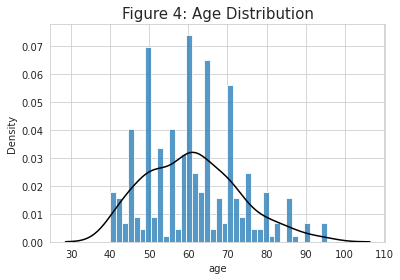

In [16]:
sns.set_style('whitegrid')

sns.histplot(data=heartFailureClinicalRecord, x='age', stat='density', binwidth=1.5)
plt.title('Figure 4: Age Distribution', fontsize=15)
sns.kdeplot(heartFailureClinicalRecord['age'], color='k')
plt.show()

##### **Histogram of serum creatinine**

The histogram has a right-skewed distribution, indicating that there are a number of patients has serum creatinine lower than 1.37 mg/dL. Most of patients has serum creatinine between 0.5 and 1.5. 

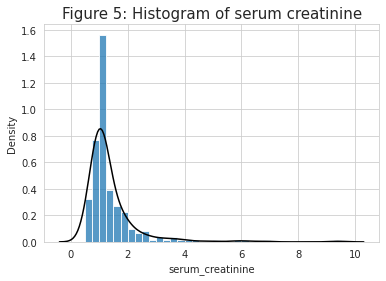

In [17]:
sns.set_style('whitegrid')

sns.histplot(data=heartFailureClinicalRecord, x='serum_creatinine', stat='density', binwidth=0.25)
plt.title('Figure 5: Histogram of serum creatinine', fontsize=15)
sns.kdeplot(heartFailureClinicalRecord['serum_creatinine'], color='k')
plt.show()

##### **Histogram of ejection fraction**

The histogram is normally distributed and patient's ejection fraction ranges from 14 to 65% with an average of around 37%.

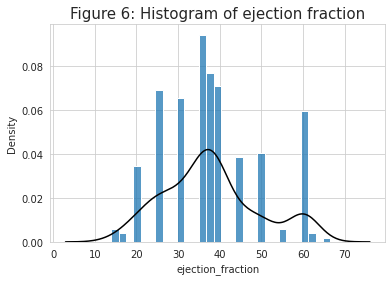

In [18]:
sns.set_style('whitegrid')

sns.histplot(data=heartFailureClinicalRecord, x='ejection_fraction', stat='density', binwidth=1.75)
plt.title('Figure 6: Histogram of ejection fraction', fontsize=15)
sns.kdeplot(heartFailureClinicalRecord['ejection_fraction'], color='k')
plt.show()

##### **Histogram of serum sodium**

The histogram is normally distributed.

There is a significant difference in patients' serum sodium. As we can see, most of patients have serum sodium around 137 mEq/L. However, it appears some patients with around 149 (pretty high) and even some with only approximate 125 (pretty low).

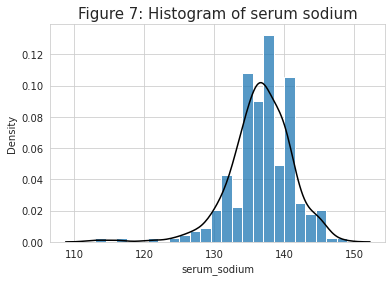

In [19]:
sns.set_style('whitegrid')

sns.histplot(data=heartFailureClinicalRecord, x='serum_sodium', stat='density', binwidth=1.5)
plt.title('Figure 7: Histogram of serum sodium', fontsize=15)
sns.kdeplot(heartFailureClinicalRecord['serum_sodium'], color='k')
plt.show()

##### **Box plot of creatinine phosphokinase**

The box plot is comparatively short and right skewed. 

Most of patients have creatinine phosphokinase between 115 and 582 mcg/L. Nonetheless, it is shown that there are a number of patients with creatinine phosphokinase higher than 1282.5 mcg/L.

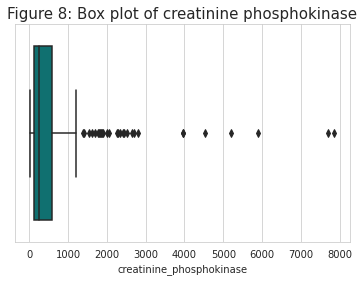

In [20]:
sns.boxplot(data=heartFailureClinicalRecord, x='creatinine_phosphokinase', color = 'teal')
plt.title("Figure 8: Box plot of creatinine phosphokinase", fontsize = 15)
plt.show()

##### **Box plot of platelets**

The box plot is slightly right skewed with a number of outliers smaller than 76500 and greater than 440500 kiloplatelets/mL.

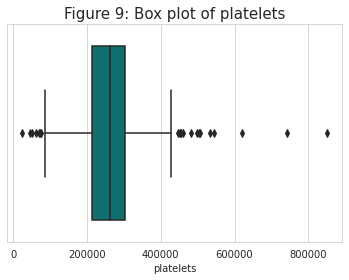

In [21]:
sns.boxplot(data=heartFailureClinicalRecord, x='platelets', color = 'teal')
plt.title("Figure 9: Box plot of platelets", fontsize = 15)
plt.show()

### **Explore the relationship between pairs of attributes**

##### **Age Distribution vs Death Event**

For this visualisation, it was assumed that most of the deaths would occur at an older age, however, deaths appear to be uniform across the age range. The proportion of deaths is higher at ages above 70. 

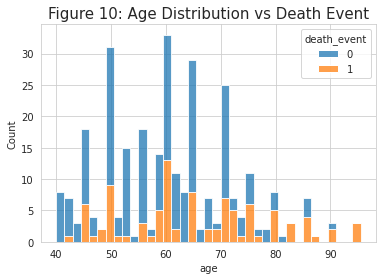

In [22]:
sns.histplot(data=heartFailureClinicalRecord, x='age', binwidth=1.5, hue='death_event', multiple='stack' )
plt.title('Figure 10: Age Distribution vs Death Event', fontsize=15)
plt.show()

##### **Creatinine Phosphokinase vs Death Event**

This graph is right skewed and suggests that deaths occured within normal CPK levels (24-200 mcg/L). It was assumed that greater CPK levels would be closer associated with deaths as elevated levels of CPK are usually a sign of heart attacks and diseases. 

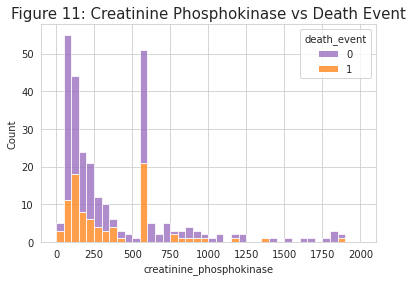

In [23]:
sns.histplot(data=heartFailureClinicalRecord, x='creatinine_phosphokinase', bins=40, binrange=(0,2000), hue='death_event', palette=["C4", "C1"], multiple='stack')
plt.title('Figure 11: Creatinine Phosphokinase vs Death Event', fontsize=15)
plt.show()

##### **Ejection Fraction Distribution vs Death Event**

This graph is also right skewed in term of death events, showing that those with lower ejection fraction percentages are more likely to die. This aligns with our thinking, as under a heart event the heart may fail and pump less blood out of the left ventricle. 

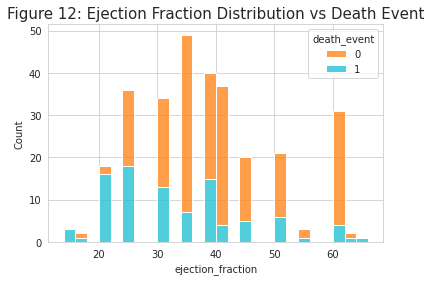

In [24]:
sns.histplot(data=heartFailureClinicalRecord, x='ejection_fraction', color='tab:cyan', binwidth=2, hue='death_event', palette=['C1','C9'], multiple='stack')
plt.title('Figure 12: Ejection Fraction Distribution vs Death Event', fontsize=15)
plt.show()

##### **Platelets vs Death Event**

The histogram shows a normal distribution with low skewness. There isn't much of a relationship between the variables. 

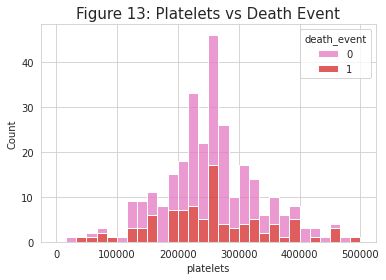

In [25]:
sns.histplot(data=heartFailureClinicalRecord, x='platelets', color='tab:red', binrange=(0,500000), bins=30, hue='death_event', palette=['C6','C3'], multiple='stack')
plt.title('Figure 13: Platelets vs Death Event', fontsize=15)
plt.show()

##### **Serum Creatinine vs Death Event**

Appears that the distribution of Serum Creatinine is also right skewed. Normal serum creatinine ranges from 0.9 to 1.3 mg/dL. The graph shows that with increasing serum creatinine there is a increasing proportion of deaths. 

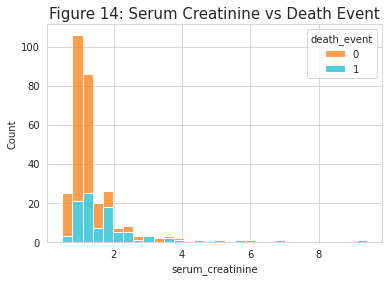

In [26]:
sns.histplot(data=heartFailureClinicalRecord, x='serum_creatinine', hue='death_event', palette=['C1','C9'], bins=30, multiple='stack')
plt.title('Figure 14: Serum Creatinine vs Death Event', fontsize=15)
plt.show()

##### **Serum Sodium vs Death Event**

This distribution is left skewed with a normal serum sodium range of 135 to 145mEq/L. Most of those that died were within the normal serum sodium range. Values below 135 causes hyponatremia due to renal failure or heart failure. 

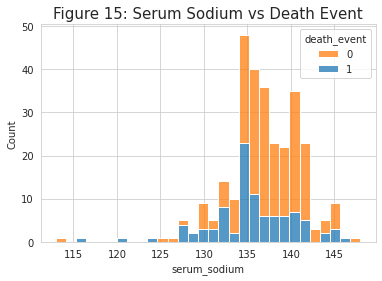

In [27]:
sns.histplot(data=heartFailureClinicalRecord, x='serum_sodium', hue='death_event',palette=['C1','C0'], bins=30, multiple='stack')
plt.title('Figure 15: Serum Sodium vs Death Event', fontsize=15)
plt.show()

##### **Distribution of Age vs Diabetes**

There doesn't appear to be any special relationship between the two variables, the expected result would be a higher frequency of diabetics as age increases. 

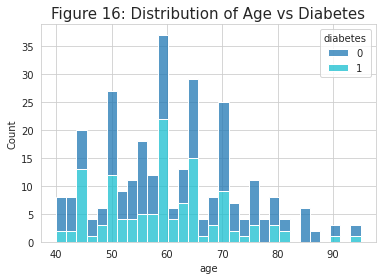

In [28]:
sns.histplot(data=heartFailureClinicalRecord, x='age', hue='diabetes', bins=30,palette=['C0','C9'], multiple='stack')
plt.title('Figure 16: Distribution of Age vs Diabetes', fontsize=15)
plt.show()

##### **Distribution of Age vs Anaemia**

High propertion of anemia as age increases, appears that a lot of the patients had anemia in general. 


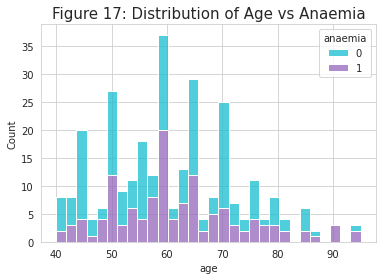

In [29]:
sns.histplot(data=heartFailureClinicalRecord, x='age', hue='anaemia', bins=30,palette=['C9','C4'], multiple='stack')
plt.title('Figure 17: Distribution of Age vs Anaemia', fontsize=15)
plt.show()

##### **Distribution of Age vs High Blood Pressure**

Generally blood pressure rises as age increases. Unable to see any special relationship between the two variables in this sample.


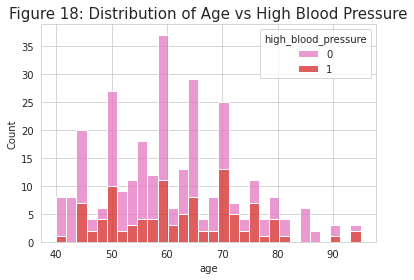

In [30]:
sns.histplot(data=heartFailureClinicalRecord, x='age', hue='high_blood_pressure', bins=30,palette=['C6','C3'], multiple='stack')
plt.title('Figure 18: Distribution of Age vs High Blood Pressure', fontsize=15)
plt.show()

##### **Distribution of Age vs Smoking**

There does not seem to be any association between age and smoking.


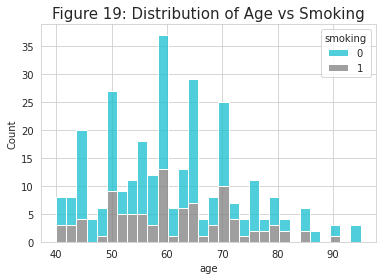

In [31]:
sns.histplot(data=heartFailureClinicalRecord, x='age', hue='smoking', bins=30,palette=['C9','C7'], multiple='stack')
plt.title('Figure 19: Distribution of Age vs Smoking', fontsize=15)
plt.show()

##### **Gender vs Death Event**

There is a greater proportion of men than female in the sample data (65.3% to 34.7%). The percentage of men that have died is double of women (20.9% to 11.1%), this is probably due to the male to female ratio in the sample population.

In [32]:
age1 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["sex"]==1)]
age2 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["sex"]==1)]
age3 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["sex"]==0)]
age4 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["sex"]==0)]

In [33]:
label1='Male', 'Female'
label2='Male - Survived', 'Male - Died', 'Female - Survived', 'Female - Died'
size1 = [(len(age1)+len(age2)), (len(age3)+len(age4))]
size2 = [len(age1), len(age2), len(age3), len(age4)]

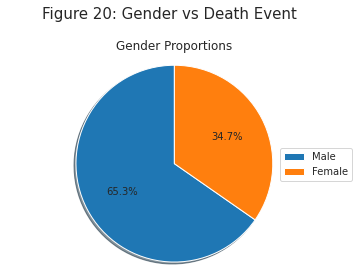

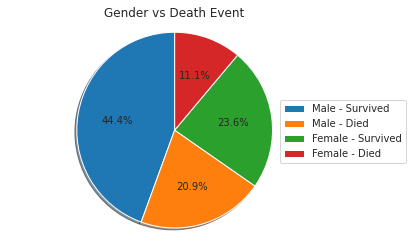

In [34]:
plt.suptitle("Figure 20: Gender vs Death Event", fontsize=15, y=1.05)

plt.figure(0)
ax1 = plt.subplot()
ax1.pie(size2, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(label2, loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
ax1.set_title('Gender vs Death Event')

plt.figure(1)
ax2 = plt.subplot()
ax2.pie(size1, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.legend(label1,loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
ax2.set_title('Gender Proportions')

plt.show()

##### **Diabetes vs Death Event**

The piechart showed that the percentage of those with diabetes and died is lower than those that died without diabetes (13.5% against 18.5%), suggesting that maybe diabetes does not have a significant contribution to predicting a death event.

In [35]:
d1 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 0) & (heartFailureClinicalRecord['diabetes']==0)]
d2 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 0) & (heartFailureClinicalRecord['diabetes']==1)]
d3 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 1) & (heartFailureClinicalRecord['diabetes']==0)]
d4 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 1) & (heartFailureClinicalRecord['diabetes']==1)]

In [36]:
labels1 = 'No Diabetes', 'Diabetes'
labels2 = 'No Diabetes - Survived', 'Diabetes - Survived', 'No diabetes - Died', 'Diabetes - Died'
size1 = [(len(d1)+len(d3)), (len(d2)+len(d4))]
size2 = [len(d1),len(d2),len(d3),len(d4)]

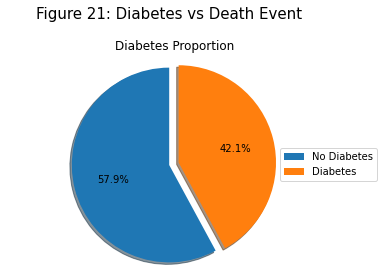

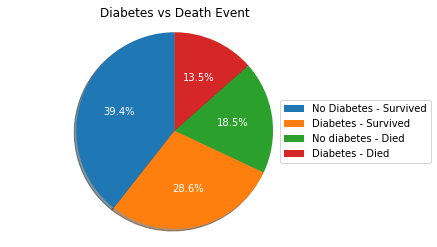

In [37]:
sns.reset_orig()
plt.suptitle("Figure 21: Diabetes vs Death Event", fontsize=15, y=1.05)

plt.figure(0)
ax1 = plt.subplot()
ax1.pie(size2, autopct='%1.1f%%', shadow=True, startangle=90, textprops=dict(color='w'))
ax1.axis('equal')
ax1.legend(labels2, loc='center left', bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.title('Diabetes vs Death Event')

plt.figure(1)
explode = (0.1,0)
ax2 = plt.subplot()
ax2.pie(size1, autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
ax2.legend(labels1, loc='center left', bbox_to_anchor=(0.8, 0, 0.5, 1))
ax2.axis('equal')
plt.title('Diabetes Proportion')

plt.show()

##### **Anaemia vd Death Event**

This pie chart shows that those without anemia had a higher percentage of deaths than those with anemia and died. This could imply that anemia isn't a big cause of deaths.

In [38]:
a1 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 0) & (heartFailureClinicalRecord['anaemia']==0)]
a2 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 0) & (heartFailureClinicalRecord['anaemia']==1)]
a3 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 1) & (heartFailureClinicalRecord['anaemia']==0)]
a4 = heartFailureClinicalRecord[(heartFailureClinicalRecord['death_event'] == 1) & (heartFailureClinicalRecord['anaemia']==1)]

In [39]:
labela1 = 'No Anaemia', 'Anaemia'
labela2 = 'No Anaemia - Survived', 'Anaemia - Survived', 'No Anaemia - Died', 'Anaemia - Died'
sizea1 = [len(a2)+len(a4), len(a1)+len(a3)]
sizea2 = [len(a1),len(a3),len(a2),len(a4)]

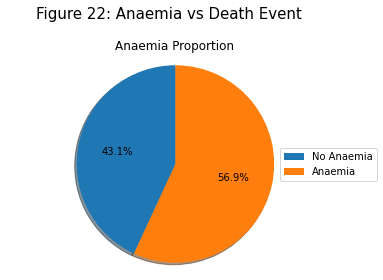

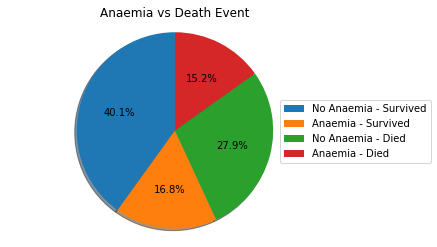

In [40]:
plt.suptitle("Figure 22: Anaemia vs Death Event", fontsize=15, y=1.05)

plt.figure(0)
ax1 = plt.subplot()
ax1.pie(sizea2, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(labela2, loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('Anaemia vs Death Event')

plt.figure(1)
ax2 = plt.subplot()
ax2.pie(sizea1, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.legend(labela1,loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('Anaemia Proportion')

plt.show()

##### **High Blood Pressure vs Death Event**

The pie chart showed that those with high blood pressure and died were only 12.8%. 
However, 65% of the population were free from high blood pressure. We assumed that those with high blood pressure were more likely to suffer from a heart attack and died.


In [41]:
b1 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["high_blood_pressure"]==0)]
b2 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["high_blood_pressure"]==0)]
b3 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["high_blood_pressure"]==1)]
b4 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["high_blood_pressure"]==1)]

In [42]:
label1 = 'No High Blood Pressure', 'High Blood Pressure'
label2 = 'No High BP - Survived', 'No High BP - Died', 'High BP - Survived', 'High BP - Died'
size1 = [(len(b1)+len(b2)),(len(b3)+len(b4))]
size2 = [len(b1), len(b2), len(b3), len(b4)]

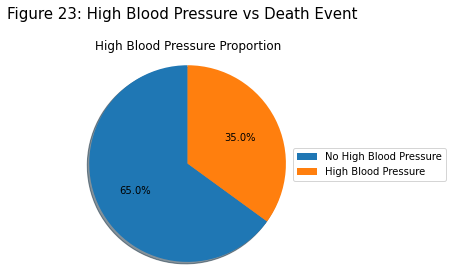

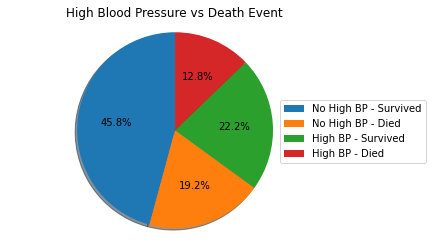

In [43]:
plt.suptitle("Figure 23: High Blood Pressure vs Death Event", fontsize=15, y=1.05)

plt.figure(0)
ax1 = plt.subplot()
ax1.pie(size2, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(label2, loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('High Blood Pressure vs Death Event')

plt.figure(1)
ax2 = plt.subplot()
ax2.pie(size1, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.legend(label1,loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('High Blood Pressure Proportion')

plt.show()

##### **Smoking vs Death Event**

These charts showed that two-thirds of the sample population were non-smokers. Of those non-smokers, 21.9% died whereas 10.1% of smokers died. This tells us that of those that died, not many were smokers in the sample population.



In [44]:
s1 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["smoking"]==0)]
s2 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["smoking"]==0)]
s3 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==0) & (heartFailureClinicalRecord["smoking"]==1)]
s4 = heartFailureClinicalRecord[(heartFailureClinicalRecord["death_event"]==1) & (heartFailureClinicalRecord["smoking"]==1)]

In [45]:
label1 = 'No Smoking', 'Smoking'
label2 = 'No Smoking - Survived', 'No Smoking - Died', 'Smoking - Survived', 'Smoking - Died'
size1 = [(len(s1)+len(s2)),(len(s3)+len(s4))]
size2 = [len(s1), len(s2), len(s3), len(s4)]

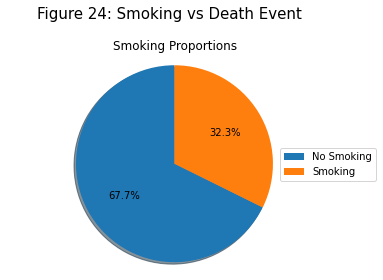

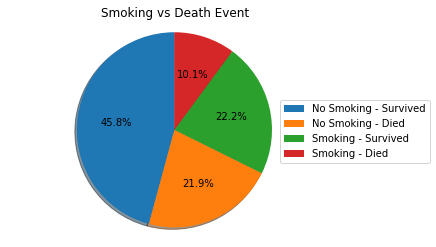

In [46]:
plt.suptitle("Figure 24: Smoking vs Death Event", fontsize=15, y=1.05)

plt.figure(0)
ax1 = plt.subplot()
ax1.pie(size2, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.legend(label2, loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('Smoking vs Death Event')

plt.figure(1)
ax2 = plt.subplot()
ax2.pie(size1, autopct='%1.1f%%', shadow=True, startangle=90)
ax2.axis('equal')
ax2.legend(label1,loc='center left', bbox_to_anchor=(0.8,0,0.5,1))
plt.title('Smoking Proportions')

plt.show()

# **Data Modelling**


### **Feature Selection**

##### **Correlation matrix**

As obtained from visualization and the correlation matrix, **serum creatinine**, **ejection fraction** and **age** are top 3 important features regarding patient's heart failure.

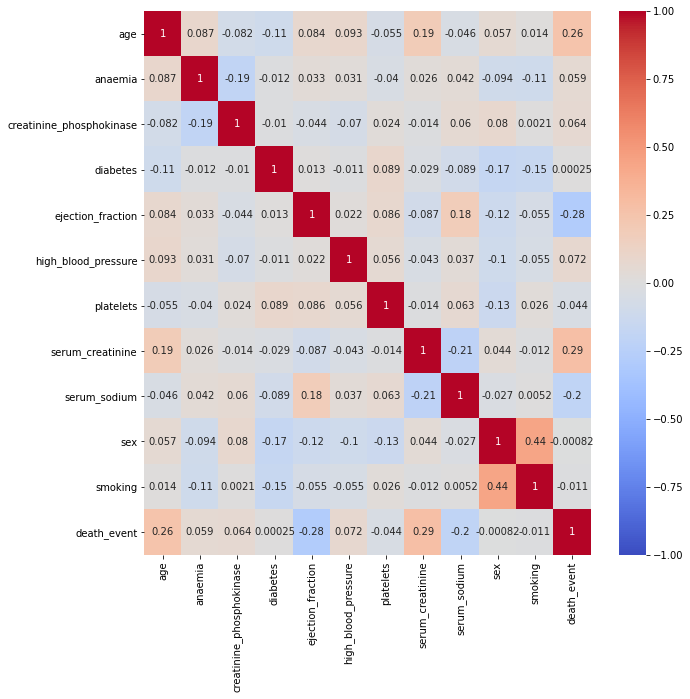

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(heartFailureClinicalRecord.corr(), vmin=-1, cmap='coolwarm', annot=True)

### **K-Nearest Neighbors**

##### **Extract data and generate train/test split**

In [48]:
X1 = np.array(heartFailureClinicalRecord)
X = X1[:, :11]
Y = X1[:, 11]

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2)

##### **Building an optimised model**

In [50]:
def tune_k() -> None:
    error_rate = []
    for i in range(1,40):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        error_rate.append(np.mean(pred_i != Y_test))
    print("Min error rate is: " + str(min(error_rate)) + "\n")
    print(str(error_rate))

##### **Feature selection with Hill Climbing**

In [51]:
new_Ind = []
cur_MaxScore =  0.0
col_num = 10
col_Ind_Random = shuffle(range(0, col_num), random_state = 2)

In [52]:
for cur_f in range(0, col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = X[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, Y, test_size=0.2, random_state=1)
    clf = KNeighborsClassifier(14, weights='distance', p=2)
    fit =clf.fit(x_train, y_train)
    cur_Score = clf.score(x_test, y_test)
    if cur_Score <= cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\n")
print(new_Ind)

Score with 1 selected features: 0.65
Score with 2 selected features: 0.7166666666666667


[4, 0]


##### **Evaluate the model with all features**

In [53]:
tune_k()

Min error rate is: 0.26666666666666666

[0.5333333333333333, 0.36666666666666664, 0.45, 0.31666666666666665, 0.4, 0.38333333333333336, 0.36666666666666664, 0.35, 0.35, 0.3, 0.3, 0.31666666666666665, 0.31666666666666665, 0.3, 0.3, 0.3, 0.3, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.3, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666]


In [54]:
clf = KNeighborsClassifier(22)
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                     weights='uniform')

In [55]:
predicted = clf.predict(X_test)
predicted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
cm = confusion_matrix(Y_test, predicted)
print(cm)

[[44  0]
 [16  0]]


In [57]:
print(classification_report(Y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.85        44
         1.0       0.00      0.00      0.00        16

    accuracy                           0.73        60
   macro avg       0.37      0.50      0.42        60
weighted avg       0.54      0.73      0.62        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
print("[Train/test split] score: {:.5f}".format(clf.score(X_test, Y_test)))

[Train/test split] score: 0.73333


In [59]:
kf = KFold(n_splits=5, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [60]:
KFold(n_splits=5, random_state=None, shuffle=False)

KFold(n_splits=5, random_state=None, shuffle=False)

In [61]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

TRAIN: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296] TEST: [ 0  1  2  3  4  5  6  7

In [62]:
for k, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    clf.fit(X_train, Y_train)
    print("[fold {0}] score: {1:.5f}".format(k, clf.score(X_test, Y_test)))

[fold 0] score: 0.75000
[fold 1] score: 0.81667
[fold 2] score: 0.72881
[fold 3] score: 0.71186
[fold 4] score: 0.35593


##### **Evaluate the model with features from hill climbing**

In [63]:
X1 = X[:, new_Ind]
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y, test_size=0.2, random_state=1)

In [64]:
tune_k()

Min error rate is: 0.3

[0.31666666666666665, 0.36666666666666664, 0.3, 0.35, 0.31666666666666665, 0.31666666666666665, 0.3, 0.31666666666666665, 0.31666666666666665, 0.36666666666666664, 0.3, 0.3, 0.31666666666666665, 0.3, 0.31666666666666665, 0.3, 0.31666666666666665, 0.3, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.31666666666666665, 0.3, 0.3333333333333333, 0.31666666666666665, 0.35, 0.3333333333333333, 0.38333333333333336, 0.35, 0.38333333333333336, 0.35, 0.36666666666666664, 0.36666666666666664, 0.38333333333333336, 0.38333333333333336, 0.38333333333333336, 0.38333333333333336, 0.36666666666666664, 0.36666666666666664]


In [65]:
clf = KNeighborsClassifier(12)
fit = clf.fit(X_train, Y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(Y_test, y_pre)

In [66]:
print(cm)

[[34  2]
 [16  8]]


In [67]:
print(classification_report(Y_test, y_pre))

              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79        36
         1.0       0.80      0.33      0.47        24

    accuracy                           0.70        60
   macro avg       0.74      0.64      0.63        60
weighted avg       0.73      0.70      0.66        60



In [68]:
clf = KNeighborsClassifier(12, weights='distance', p=2)
fit = clf.fit(X_train, Y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(Y_test, y_pre)

In [69]:
print(cm)

[[33  3]
 [14 10]]


In [70]:
print(classification_report(Y_test, y_pre))

              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80        36
         1.0       0.77      0.42      0.54        24

    accuracy                           0.72        60
   macro avg       0.74      0.67      0.67        60
weighted avg       0.73      0.72      0.69        60



##### **Evaluate the model with serum creatinine, ejection fraction and age features**

In [71]:
features_index = [0, 4, 7]
data = X[:, features_index]

In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.2, random_state=1)

In [73]:
max_score = 0.0
k = 0
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    score = accuracy_score(Y_test, pred_i)
    if(score > max_score):
        max_score = score
        k = i
print("Best accuracy score is: " + str(max_score) + " for k = " + str(k))

Best accuracy score is: 0.7166666666666667 for k = 5


In [74]:
clf = KNeighborsClassifier(k)
fit = clf.fit(X_train, Y_train)
y_pre = fit.predict(X_test)
cm = confusion_matrix(Y_test, y_pre)
print(cm)

[[34  2]
 [15  9]]


In [75]:
print(classification_report(Y_test, y_pre))

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80        36
         1.0       0.82      0.38      0.51        24

    accuracy                           0.72        60
   macro avg       0.76      0.66      0.66        60
weighted avg       0.74      0.72      0.69        60



In [76]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
average_score = 0.0

for k, (train_index, test_index) in enumerate(kf.split(data)):
    X_train, X_test = data[train_index], data[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print("[fold {0}] score: {1: .5f}".format(k, score))
    average_score += score

print("\nAverage score is: " + str(average_score/5))

[fold 0] score:  0.71667
[fold 1] score:  0.68333
[fold 2] score:  0.71186
[fold 3] score:  0.71186
[fold 4] score:  0.74576

Average score is: 0.7138983050847457


### **Decision Tree**

##### **Extract data and generate train/test split**

In [77]:
x = heartFailureClinicalRecord.drop('death_event', axis=1)
y = heartFailureClinicalRecord['death_event']

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(237, 11)
(237,)
(60, 11)
(60,)


##### **Building an optimised model**

We decided to tune **min samples split** and **min samples leaf**.

In [79]:
def cross_validation(data: pd.Series, model: DecisionTreeClassifier) -> float:
    kf = KFold(n_splits=5, random_state=3, shuffle=True)
    average_score = 0.0
  
    for k, (train_index, test_index) in enumerate(kf.split(data)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
        fit = model.fit(X_train, Y_train)
        predicted = fit.predict(X_test) 
        score = f1_score(Y_test, predicted)
        average_score += score
    average_score /= 5
    return average_score

def tune_parameters(data: pd.Series):
    min_samples_split = range(2,20)
    min_samples_leaf = range(1,20)
    split = 0
    leaf = 0
    max_score = 0.0
    for n in min_samples_split:
        for m in min_samples_leaf:
            dt = DecisionTreeClassifier(min_samples_split=n, min_samples_leaf=m)
            score = cross_validation(data, dt)
            if score > max_score:
                max_score = score
                split = n
                leaf = m
    print('Best F1 score is: ' + str(max_score))
    print('Min_samples_split: ' + str(split))
    print('Min_samples_leaf: ' + str(leaf))

    return (split, leaf)

In [80]:
def kfolds(data: pd.Series, model: DecisionTreeClassifier) -> None:
    kf = KFold(n_splits=5, random_state=3, shuffle=True)
    average_score = 0.0
  
    for k, (train_index, test_index) in enumerate(kf.split(data)):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
        fit = model.fit(X_train, Y_train)
        predicted = fit.predict(X_test) 
        score = f1_score(Y_test, predicted)
        print("[fold {0}] score: {1: .5f}".format(k, score))
        average_score += score
    average_score /= 5
    print("\nAverage F1 score for 5 folds: " + str(average_score))

##### **Feature selection with Hill Climbing**

In [81]:
dtc = DecisionTreeClassifier()
col_num = x.shape[1]

new_Ind = []
cur_Maxscore = 0.0
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)

for cur_f in range(0, col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    new_data = x.iloc[:, new_Ind].copy()
    x_train, x_test, y_train, y_test = train_test_split(new_data, y, test_size = 0.2, random_state = 1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    if cur_Score <= cur_Maxscore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_Maxscore = cur_Score
        print("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))

print("\n")  
print(new_Ind)
print("\n")
hill_climbing_features = x.columns[new_Ind]
print(hill_climbing_features)

Score with 1 selected features: 0.5
Score with 2 selected features: 0.5666666666666667
Score with 3 selected features: 0.6333333333333333
Score with 4 selected features: 0.7
Score with 5 selected features: 0.7166666666666667


[2, 3, 9, 7, 10]


Index(['creatinine_phosphokinase', 'diabetes', 'sex', 'serum_creatinine',
       'smoking'],
      dtype='object')


##### **Evaluate the model with all features**

In [82]:
(x_split, x_leaf) = tune_parameters(x)
dt = DecisionTreeClassifier(min_samples_split = x_split, min_samples_leaf = x_leaf)

all_features_fit = dt.fit(x_train, y_train)
all_features_predicted = all_features_fit.predict(x_test)

all_features_cm = confusion_matrix(y_test, all_features_predicted)

print("\n")
print(all_features_cm)
print(classification_report(y_test, all_features_predicted))
print(accuracy_score(y_test, all_features_predicted))

Best F1 score is: 0.6067094017094018
Min_samples_split: 2
Min_samples_leaf: 16


[[30  6]
 [15  9]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        36
           1       0.60      0.38      0.46        24

    accuracy                           0.65        60
   macro avg       0.63      0.60      0.60        60
weighted avg       0.64      0.65      0.63        60

0.65


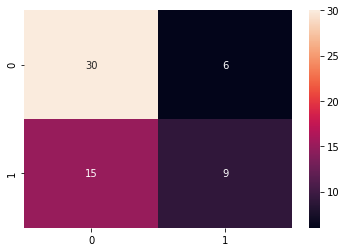

In [83]:
sns.heatmap(all_features_cm, annot=True)

In [84]:
kfolds(x, dt)

[fold 0] score:  0.62500
[fold 1] score:  0.72727
[fold 2] score:  0.50000
[fold 3] score:  0.56410
[fold 4] score:  0.61111

Average F1 score for 5 folds: 0.6054972804972805


##### **Evaluate the model with features from hill climbing**

In [85]:
hill_climbing_x = x[hill_climbing_features]
hill_climbing_x.head()

,creatinine_phosphokinase,diabetes,sex,serum_creatinine,smoking
2,157,0,0,1.5,0
3,582,0,1,0.8,1
4,3964,1,0,6.8,0
5,737,0,1,1.5,1
6,1808,0,1,0.7,1


In [86]:
x_train, x_test, y_train, y_test = train_test_split(hill_climbing_x, y, test_size=0.2, random_state=2)

In [87]:
(hill_climbing_x_split, hill_climbing_x_leaf) = tune_parameters(hill_climbing_x)
dt_hill_climbing = DecisionTreeClassifier(min_samples_split = hill_climbing_x_split, min_samples_leaf = hill_climbing_x_leaf)

hill_climbing_fit = dt_hill_climbing.fit(x_train, y_train)
hill_climbing_predicted = hill_climbing_fit.predict(x_test)

hill_climbing_cm = confusion_matrix(y_test, hill_climbing_predicted)

print("\n")
print(hill_climbing_cm)
print(classification_report(y_test, hill_climbing_predicted))
print(accuracy_score(y_test, hill_climbing_predicted))

Best F1 score is: 0.49666081666081674
Min_samples_split: 2
Min_samples_leaf: 12


[[38  6]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84        44
           1       0.57      0.50      0.53        16

    accuracy                           0.77        60
   macro avg       0.70      0.68      0.69        60
weighted avg       0.76      0.77      0.76        60

0.7666666666666667


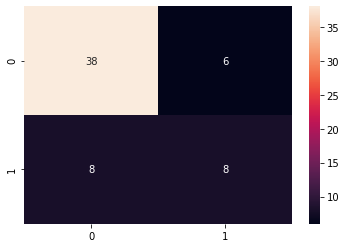

In [88]:
sns.heatmap(hill_climbing_cm, annot=True)

In [89]:
kfolds(hill_climbing_x, dt_hill_climbing)

[fold 0] score:  0.57143
[fold 1] score:  0.48485
[fold 2] score:  0.40000
[fold 3] score:  0.43243
[fold 4] score:  0.59459

Average F1 score for 5 folds: 0.49666081666081674


##### **Evaluate the model with serum creatinine, ejection fraction and age features**

In [90]:
features = ['age', 'serum_creatinine', 'ejection_fraction']
new_x = x[features]
new_x.head()

,age,serum_creatinine,ejection_fraction
2,65.0,1.5,65
3,50.0,0.8,62
4,60.0,6.8,62
5,60.0,1.5,60
6,53.0,0.7,60


In [91]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.2, random_state=5)

In [92]:
(new_x_split, new_x_leaf) = tune_parameters(new_x)
dt_features = DecisionTreeClassifier(min_samples_split = new_x_split, min_samples_leaf = new_x_leaf)

new_fit = dt_features.fit(x_train, y_train)
new_predicted = new_fit.predict(x_test)

new_cm = confusion_matrix(y_test, new_predicted)

print("\n")
print(new_cm)
print(classification_report(y_test, new_predicted))
print(accuracy_score(y_test, new_predicted))

Best F1 score is: 0.6277262091896239
Min_samples_split: 12
Min_samples_leaf: 4


[[39  5]
 [ 5 11]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        44
           1       0.69      0.69      0.69        16

    accuracy                           0.83        60
   macro avg       0.79      0.79      0.79        60
weighted avg       0.83      0.83      0.83        60

0.8333333333333334


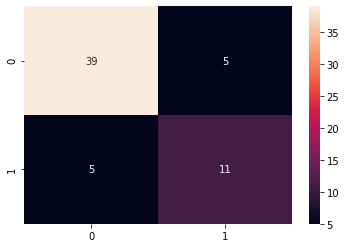

In [93]:
sns.heatmap(new_cm, annot=True)

In [94]:
kfolds(new_x, dt_features)

[fold 0] score:  0.64286
[fold 1] score:  0.58065
[fold 2] score:  0.63415
[fold 3] score:  0.57895
[fold 4] score:  0.62857

Average F1 score for 5 folds: 0.6130334885206723


In [95]:
feature_names = ['age', 'serum_creatinine', 'ejection_fraction']
class_names = ['0', '1']

In [96]:
text_presentation = tree.export_text(dt_features, feature_names=feature_names)
print(text_presentation)

|--- serum_creatinine <= 1.81
|   |--- ejection_fraction <= 27.50
|   |   |--- age <= 51.50
|   |   |   |--- class: 0
|   |   |--- age >  51.50
|   |   |   |--- ejection_fraction <= 22.50
|   |   |   |   |--- class: 1
|   |   |   |--- ejection_fraction >  22.50
|   |   |   |   |--- serum_creatinine <= 1.05
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- serum_creatinine >  1.05
|   |   |   |   |   |--- serum_creatinine <= 1.35
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- serum_creatinine >  1.35
|   |   |   |   |   |   |--- class: 1
|   |--- ejection_fraction >  27.50
|   |   |--- age <= 79.50
|   |   |   |--- ejection_fraction <= 32.50
|   |   |   |   |--- serum_creatinine <= 1.40
|   |   |   |   |   |--- age <= 47.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  47.00
|   |   |   |   |   |   |--- age <= 54.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  54.50
|   |   |   |   |   |   |   |--- class: 0
| 